# This notebook examines a local earthquake that was recorded by the Whidbey DAS experiment.
Specifically, it produces Figure 5 in Lipovsky et al., 2023.

In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd
from dasquakes import *
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame

import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [2]:
# events = search(starttime = datetime.datetime(2022, 3, 17, 0, 0), 
#                 endtime   = datetime.datetime.now(),
#                 maxradiuskm=200,
#                 maxmagnitude=5.0,
#                 latitude=47.65, 
#                 longitude=-122.31)
# event_df = get_summary_data_frame(events)

events = search(starttime = datetime.datetime(2022, 3, 17, 0, 0), 
                endtime   = datetime.datetime.now(),
                maxradiuskm=1000,
                maxmagnitude=6.5,
                latitude=47.65, 
                longitude=-122.31)
event_df = get_summary_data_frame(events)
# event_df.sort_values(by='magnitude')

In [3]:
detected_quakes_whidbey = ['uw61832097','uw61819867','uw61855012','us7000gxl1']
this_event_index = 0
this_id=detected_quakes_whidbey[this_event_index]

# this_id = 'nc73821036' #ferndale
# this_id =   'uw61836427'

this_event = event_df[event_df.id==this_id]
t0 = this_event['time'].iloc[0]
this_event

,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
4530,uw61832097,2022-05-17 08:07:34.400,"6 km ENE of Oso, Washington",48.299667,-121.852,3.53,3.4,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,280


In [4]:
t0

Timestamp('2022-05-17 08:07:34.400000')

In [5]:
# cable = 'seadasn'
cable = 'whidbey'
record_length = 5 #minutes

prefix, network_name, datastore = data_wrangler(cable,record_length,t0)

data,dates,attrs = open_sintela_file(prefix,
                                     t0,
                                     datastore,
                                     number_of_files=record_length,
                                     verbose=True)
x_max=data.shape[1] * attrs['SpatialSamplingInterval']

Searching for files matching: /data/data5/Converted/whidbey_2022-05-17_08-07*h5
Searching for files matching: /data/data5/Converted/whidbey_2022-05-17_08-08*h5
Searching for files matching: /data/data5/Converted/whidbey_2022-05-17_08-09*h5
Searching for files matching: /data/data5/Converted/whidbey_2022-05-17_08-10*h5
Searching for files matching: /data/data5/Converted/whidbey_2022-05-17_08-11*h5


In [6]:
low_cut = 0.3
hi_cut = 2

b,a = butter(2,(low_cut,hi_cut),'bp',fs=attrs['MaximumFrequency']*2)
data_filt = filtfilt(b,a,data,axis=0)



low_cut = 2
hi_cut = 8

b,a = butter(2,(low_cut,hi_cut),'bp',fs=attrs['MaximumFrequency']*2)
data_filt2 = filtfilt(b,a,data,axis=0)

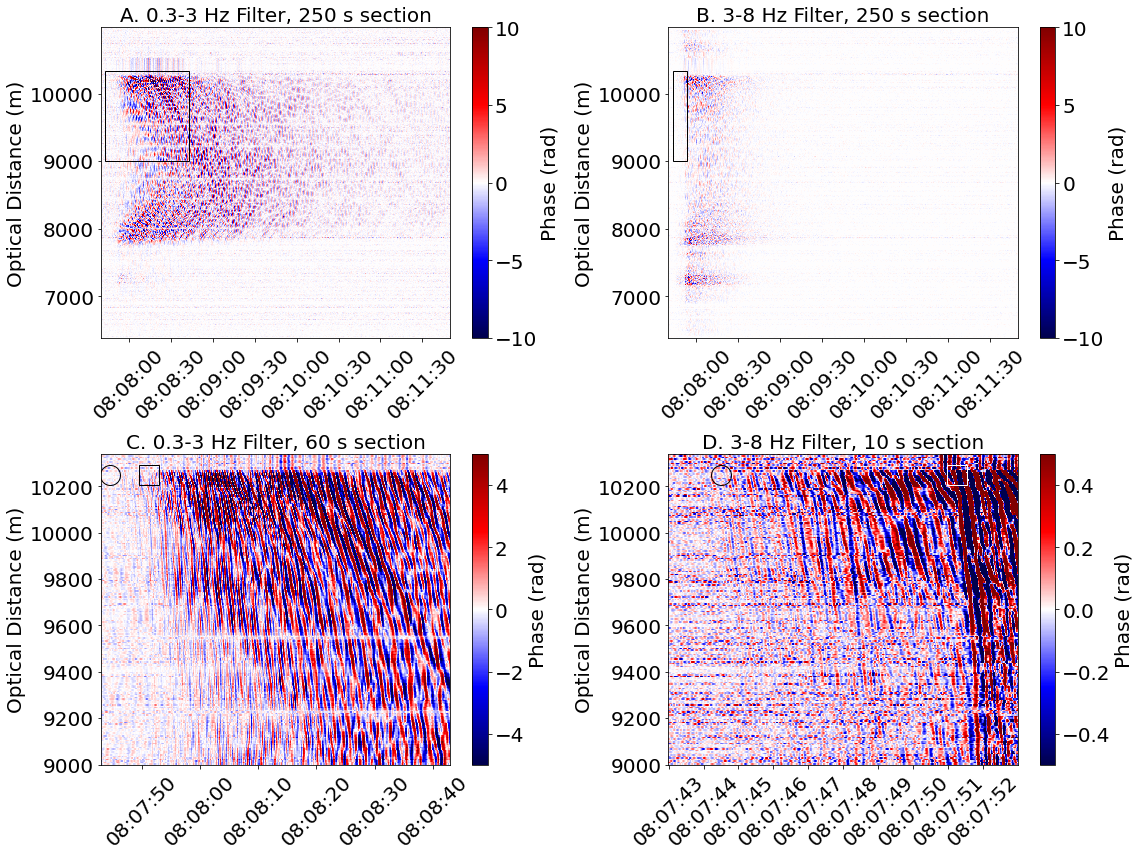

In [7]:
fig,ax=plt.subplots(2,2,figsize=(16,12))

data_filt_window = data_filt[:,:]
data_filt2_window = data_filt2[:,:]

slice_space0 = slice(1000,1720) # for 6m GL
# slice_space0 = slice(2000,3240) # for 3m GL

slice_time0 = slice(4000,29000)
x = np.linspace(0,x_max,data_filt_window.shape[1])
vm = 10

a1=ax[0][0].pcolormesh(dates[slice_time0],
               x[slice_space0],
               data_filt_window[slice_time0,slice_space0].T,
               vmin=-vm,vmax=vm,cmap='seismic')
ax[0][0].set_ylabel('Optical Distance (m)',fontsize=20)
cb=plt.colorbar(a1,ax=ax[0][0])
cb.set_label(label='Phase (rad)',size=20)
ax[0][0].set_title('A. 0.3-3 Hz Filter, 250 s section',fontsize=20)

a2=ax[0][1].pcolormesh(dates[slice_time0],
               x[slice_space0],
               data_filt2_window[slice_time0,slice_space0].T,
               vmin=-vm,vmax=vm,cmap='seismic')
cb=plt.colorbar(a2,ax=ax[0][1])
cb.set_label(label='Phase (rad)',size=20)
ax[0][1].set_title('B. 3-8 Hz Filter, 250 s section',fontsize=20)
ax[0][1].set_ylabel('Optical Distance (m)',fontsize=20)


# slice_space2 = slice(1200,1620) # for 6m GL
slice_space2 = slice(1410,1620) # for 6m GL, half of the fjord
# slice_space2 = slice(2400,3240) # for 3m GL


# slice_time2 = slice(4500,16000)
# slice_time2 = slice(4300,5800) # 15s
# slice_time2 = slice(4300,7300) # 30s
slice_time2 = slice(4300,10300) # 60s

vm=5
a3=ax[1][0].pcolormesh(dates[slice_time2],
               x[slice_space2],
               data_filt_window[slice_time2,slice_space2].T,
               vmin=-vm,vmax=vm,cmap='seismic')
cb=plt.colorbar(a3,ax=ax[1][0])
cb.set_label(label='Phase (rad)',size=20)
ax[1][0].set_title('C. 0.3-3 Hz Filter, 60 s section',fontsize=20)
ax[1][0].set_ylabel('Optical Distance (m)',fontsize=20)

# slice_space = slice(1200,1620) # for 6m GL
slice_space = slice(1410,1620) # for 6m GL, half of the fjord
slice_time = slice(4300,5300) #10s

vm=0.5
a4=ax[1][1].pcolormesh(dates[slice_time],
               x[slice_space],
               data_filt2_window[slice_time,slice_space].T,
               vmin=-vm,vmax=vm,cmap='seismic')
cb=plt.colorbar(a4,ax=ax[1][1])
cb.set_label(label='Phase (rad)',size=20)
ax[1][1].set_title('D. 3-8 Hz Filter, 10 s section',fontsize=20)
ax[1][1].set_ylabel('Optical Distance (m)',fontsize=20)


ax[1][1].plot( dates[slice_time][150],10250,'ok',markerfacecolor='none',markersize=20)
ax[1][0].plot( dates[slice_time][150],10250,'ok',markerfacecolor='none',markersize=20)
ax[1][1].plot( dates[slice_time][825],10250,'sw',markerfacecolor='none',markersize=20)
ax[1][0].plot( dates[slice_time][825],10250,'sk',markerfacecolor='none',markersize=20)




import matplotlib.patches as patches
import matplotlib.dates as mdates

# Plot rectangles
start = mdates.date2num(dates[slice_time][0])
end = mdates.date2num(dates[slice_time][-1])
width = end - start
height = x[slice_space][-1] - x[slice_space][0]
rect = patches.Rectangle((start, x[slice_space][0]), width, height, edgecolor='k',facecolor='none')
ax[0][1].add_patch(rect)

start = mdates.date2num(dates[slice_time2][0])
end = mdates.date2num(dates[slice_time2][-1])
width = end - start
height = x[slice_space2][-1] - x[slice_space2][0]
rect2 = patches.Rectangle((start, x[slice_space2][0]), width, height, edgecolor='k',facecolor='none')
ax[0][0].add_patch(rect2)

ax[0][0].tick_params(axis='x', rotation=45)
ax[0][1].tick_params(axis='x', rotation=45)
ax[1][0].tick_params(axis='x', rotation=45)
ax[1][1].tick_params(axis='x', rotation=45)

plt.tight_layout()
# plt.savefig('oso.png')
plt.show()

Compare to a local broadband seismometer:

In [10]:
from scipy.signal import butter, filtfilt

low_cut = 3
hi_cut = 8

b,a = butter(2,(low_cut,hi_cut),'bp',fs=attrs['MaximumFrequency']*2)
data_filt = filtfilt(b,a,data,axis=0)

client = Client("IRIS")

t1 = UTCDateTime( t0.replace(second=0).strftime("%Y-%m-%dT%H:%M:%S") )
dt = datetime.timedelta(minutes=record_length)
t2 = UTCDateTime( (t0.replace(second=0)+dt).strftime("%Y-%m-%dT%H:%M:%S") )

st = client.get_waveforms("UW", "SALO", "--", "HH*", t1, t2, attach_response=True)
pre_filt = (low_cut/2, low_cut, hi_cut, hi_cut*2)
st.remove_response(output='VEL', pre_filt=pre_filt)

3 Trace(s) in Stream:
UW.SALO..HHE | 2022-05-17T08:07:00.000000Z - 2022-05-17T08:12:00.000000Z | 100.0 Hz, 30001 samples
UW.SALO..HHN | 2022-05-17T08:07:00.000000Z - 2022-05-17T08:12:00.000000Z | 100.0 Hz, 30001 samples
UW.SALO..HHZ | 2022-05-17T08:07:00.000000Z - 2022-05-17T08:12:00.000000Z | 100.0 Hz, 30001 samples

(40.0, 60.0)

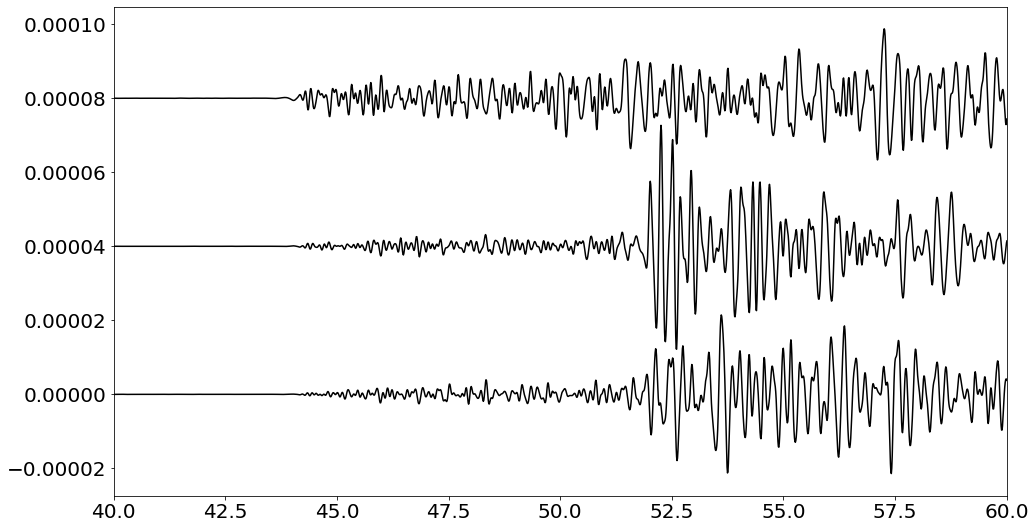

In [37]:
fig,ax=plt.subplots(figsize=(16,9))
for i,tr in enumerate(st):
    plt.plot(tr.times(),np.array(tr) + i*4e-5,'-k')
plt.xlim([40,60])